# [Create Agent with Azure AI Search](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-projects-readme?view=azure-python-preview#create-agent-with-azure-ai-search)
Azure AI Search is an enterprise search system for high-performance applications. It integrates with Azure OpenAI Service and Azure Machine Learning, offering advanced search technologies like vector search and full-text search. Ideal for knowledge base insights, information discovery, and automation.<br/><br/>
**IMPORTANT**: in order to create the index leveraging the "Import and Vectorize" wizard, the `Storage Blob Data Contributor` role on the Storage Account is needed for the Azure AI Managed Identity.

## Create a connection to Azure AI Search using CLI

1. First of all, let's check which connections we have, associated to our project mmai-hub04-prj01-fvye:
   ```az ml connection list --resource-group mmai04-rg --workspace-name mmai-hub04-prj01-fvye```
3. If the connection to the AI Search service does not exist, we may create a new yaml file with the configuration for Azure AI Search, using key-based or key-less (as in this case) authentication. **Please note that the "metadata" section must be filled as shown, including the ResourceId that must contain the connection name reporten on line 1**:
```
name: mmai-hub04-fvye-connection-AISearch
type: azure_ai_search
endpoint: https://mmai-hub04-ai-search-fvye.search.windows.net/
is_shared: true
metadata:
  ApiType: Azure
  ResourceId: /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/mmai04-rg/providers/Microsoft.Search/searchServices/mmai-hub04-fvye-connection-AISearch
  type: azure_ai_search
  ```

3. Run the command `az ml connection create --file aisearchconnection.yml --resource-group mmai04-rg --workspace-name mmai-hub04-prj01-fvye`

## Create a connection to Azure AI Search using GUI

It is also possible to create a connection using the GUI
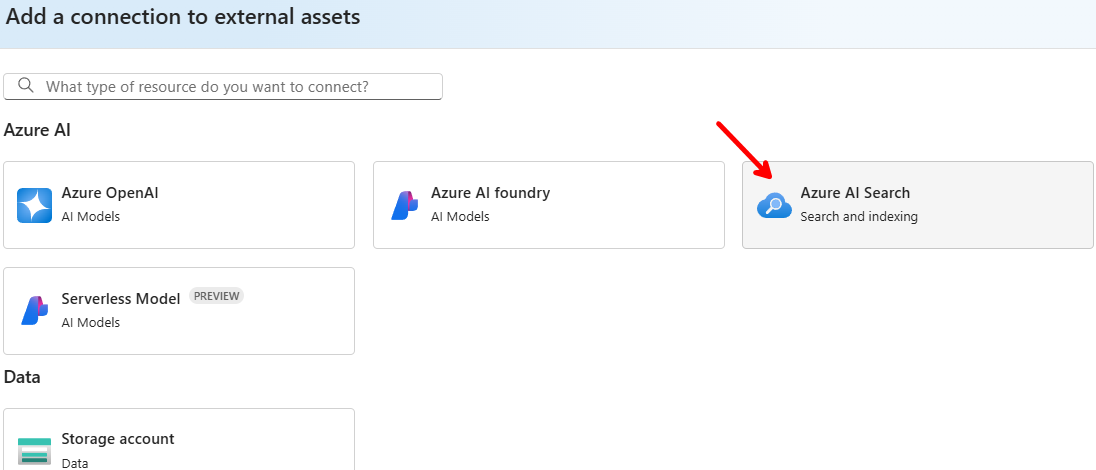
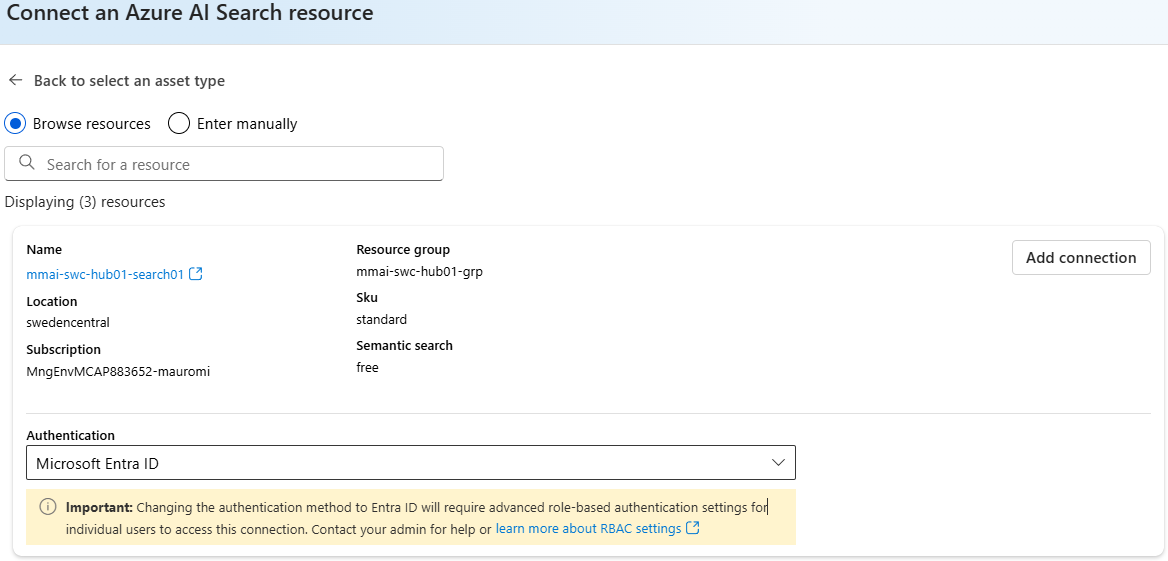

# Entra ID Authentication
The recommended and most secure connection to an Azure service is through the "Microsoft Entra ID" account, also known as "managed identity", of the service that intends to use the service.<br/>
In this case the "account" is the AI Foundry Project, which should be given the following roles on the target Azure AI Search service:
- `Search Index Data Reader`
- `Search Service Contributor`
***************
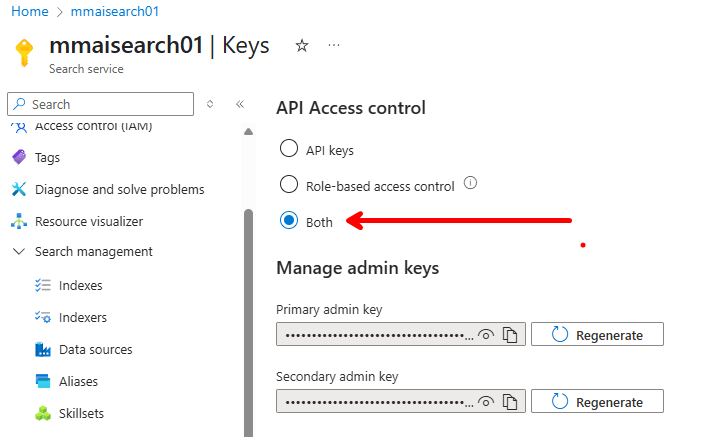
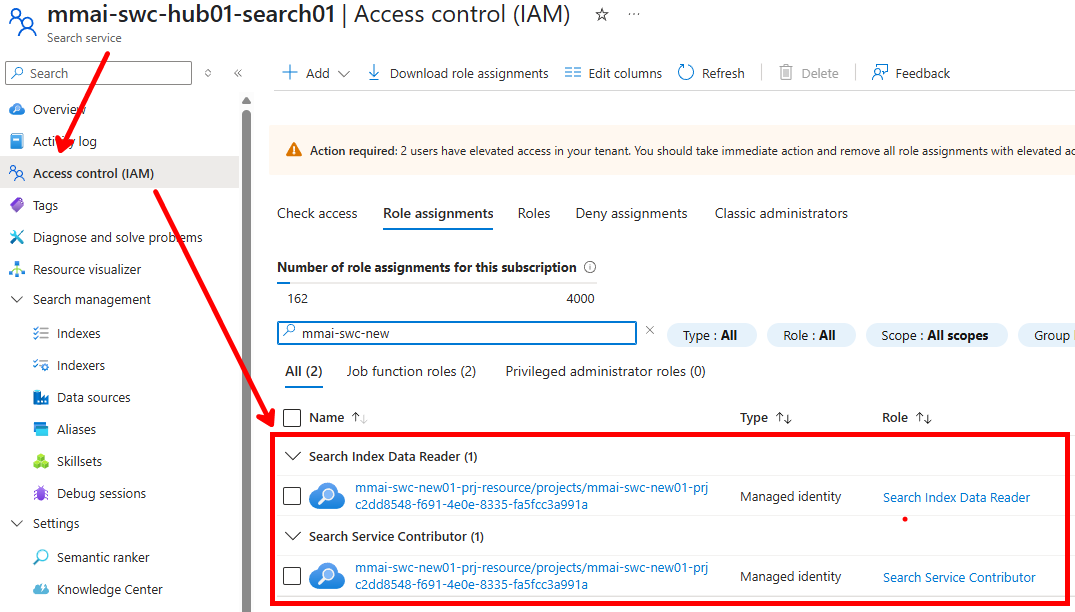

# Constants

In [1]:
import os
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
from common.agents_helper_functions_NEW import *
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:
    print("Environment variables have been loaded ;-)")


project_endpoint = os.environ["AZURE_AIF_PROJECT_ENDPOINT"]
deployment_name =  os.environ["MODEL_DEPLOYMENT_NAME"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Endpoint: <{project_endpoint}>')
print(f"azure-ai-projects library installed version: {importlib.metadata.version("azure-ai-projects")}")
print(f"azure-ai-agents library installed version: {importlib.metadata.version("azure-ai-agents")}")

Environment variables have been loaded ;-)
Project Endpoint: <https://aif01ais1lrx7.services.ai.azure.com/api/projects/aif01project01lrx7>
azure-ai-projects library installed version: 1.0.0b12
azure-ai-agents library installed version: 1.0.1


# Create AI Foundry Project Client

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

project_client

# List existing connections and highlight the "AI Search" ones

In [3]:
conn_list = list(project_client.connections.list())
conn_id = ""
for conn in conn_list:    
    if conn.type == "CognitiveSearch":
        print(f"\n\n>>>>>>> AI SEARCH FOUND: {conn}\n\n")
        conn_id = conn.id
    else:
        print(conn)

{'name': 'lrx7storage', 'id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif01grp/providers/Microsoft.CognitiveServices/accounts/aif01ais1lrx7/projects/aif01project01lrx7/connections/lrx7storage', 'type': 'AzureStorageAccount', 'target': 'https://lrx7storage.blob.core.windows.net/', 'isDefault': True, 'credentials': {'type': 'AAD'}, 'metadata': {'ApiType': 'Azure', 'ResourceId': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif01grp/providers/Microsoft.Storage/storageAccounts/lrx7storage', 'location': 'swedencentral'}}
{'name': 'lrx7cosmosdb', 'id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif01grp/providers/Microsoft.CognitiveServices/accounts/aif01ais1lrx7/projects/aif01project01lrx7/connections/lrx7cosmosdb', 'type': 'CosmosDb', 'target': 'https://lrx7cosmosdb.documents.azure.com:443/', 'isDefault': True, 'credentials': {'type': 'AAD'}, 'metadata': {'ApiType': 'Azure', 'ResourceId': '/subscriptions/eca2eddb-0f

# Chosen AI Search Connection (just for confirmation)

In [4]:
conn_id

'/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif01grp/providers/Microsoft.CognitiveServices/accounts/aif01ais1lrx7/projects/aif01project01lrx7/connections/mmaisearch01'

# Initialize `AzureAISearchTool`, adding the connection id to it

In [5]:
from azure.ai.agents.models import AzureAISearchTool

index_name = "ms-surface-specs-index"

ai_search = AzureAISearchTool(index_connection_id=conn_id, index_name=index_name)
print(f"ai_search.definitions: {ai_search.definitions}")
print(f"ai_search.resources: {ai_search.resources}")

ai_search.definitions: [{'type': 'azure_ai_search'}]
ai_search.resources: {'azure_ai_search': {'indexes': [{'index_connection_id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif01grp/providers/Microsoft.CognitiveServices/accounts/aif01ais1lrx7/projects/aif01project01lrx7/connections/mmaisearch01', 'index_name': 'ms-surface-specs-index', 'query_type': 'simple', 'filter': '', 'top_k': 5, 'index_asset_id': ''}]}}


# Create AI Foundry Agent

In [6]:
# Create agent with AI search tool and process assistant run
agent = project_client.agents.create_agent(
    model=deployment_name,
    name="aisearch-agent",
    instructions="You are a helpful assistant. Do **NOT** you your internal knowledge, please just search within the given search engine.",
    tools=ai_search.definitions,
    tool_resources=ai_search.resources,
    headers={"x-ms-enable-preview": "true"},
)

agent.items

<bound method _MyMutableMapping.items of {'id': 'asst_4uc28oSehmD21H1yGfYR0vLW', 'object': 'assistant', 'created_at': 1751384205, 'name': 'aisearch-agent', 'description': None, 'model': 'gpt-4o', 'instructions': 'You are a helpful assistant. Do **NOT** you your internal knowledge, please just search within the given search engine.', 'tools': [{'type': 'azure_ai_search'}], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {'azure_ai_search': {'indexes': [{'index_connection_id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif01grp/providers/Microsoft.CognitiveServices/accounts/aif01ais1lrx7/projects/aif01project01lrx7/connections/mmaisearch01', 'index_name': 'ms-surface-specs-index', 'query_type': 'simple', 'top_k': 5, 'filter': '', 'index_asset_id': ''}]}}, 'metadata': {}, 'response_format': 'auto'}>

# Create the thread and attach a new message to it

In [7]:
# Create a thread
thread = project_client.agents.threads.create()
print(f"Created thread: {thread}\n")


# Add a user message to the thread
from azure.ai.agents.models import MessageRole

message = project_client.agents.messages.create(
    thread_id=thread.id, 
    role=MessageRole.USER, 
    content="In the documentation I've given you, what kind of keys does the MS Surface Book keyboard include? Please answer in less than 10 words",
)
print(f"Created message: {message}")


# let's see the messages associated with the thread

list(project_client.agents.messages.list(thread_id=thread.id))

Created thread: {'id': 'thread_PEVw5t6fDb2rlm9UTuwD27e7', 'object': 'thread', 'created_at': 1751384205, 'metadata': {}, 'tool_resources': {}}

Created message: {'id': 'msg_351C2qjvlndwZRtaT1jIRvqw', 'object': 'thread.message', 'created_at': 1751384206, 'assistant_id': None, 'thread_id': 'thread_PEVw5t6fDb2rlm9UTuwD27e7', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': "In the documentation I've given you, what kind of keys does the MS Surface Book keyboard include? Please answer in less than 10 words", 'annotations': []}}], 'attachments': [], 'metadata': {}}


[{'id': 'msg_351C2qjvlndwZRtaT1jIRvqw', 'object': 'thread.message', 'created_at': 1751384206, 'assistant_id': None, 'thread_id': 'thread_PEVw5t6fDb2rlm9UTuwD27e7', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': "In the documentation I've given you, what kind of keys does the MS Surface Book keyboard include? Please answer in less than 10 words", 'annotations': []}}], 'attachments': [], 'metadata': {}}]

# Run the agent syncrhonously
Please ensure that the project managed identity has 
- Search Index Data Reader
- Search Service Contributor
<br/>
roles on the Search resource, and the Search resource allows role-based access.

In [8]:
%%time

# Run the agent
run = project_client.agents.runs.create_and_process\
    (thread_id=thread.id, agent_id=agent.id)

print(f"Run finished with status: {run.status}.\n\nRun: {run}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

Run finished with status: RunStatus.COMPLETED.

Run: {'id': 'run_GozlGZlF85ZZ4kN58VaZ1pqQ', 'object': 'thread.run', 'created_at': 1751384208, 'assistant_id': 'asst_4uc28oSehmD21H1yGfYR0vLW', 'thread_id': 'thread_PEVw5t6fDb2rlm9UTuwD27e7', 'status': 'completed', 'started_at': 1751384209, 'expires_at': None, 'cancelled_at': None, 'failed_at': None, 'completed_at': 1751384211, 'required_action': None, 'last_error': None, 'model': 'gpt-4o', 'instructions': 'You are a helpful assistant. Do **NOT** you your internal knowledge, please just search within the given search engine.', 'tools': [{'type': 'azure_ai_search'}], 'tool_resources': {}, 'metadata': {}, 'temperature': 1.0, 'top_p': 1.0, 'max_completion_tokens': None, 'max_prompt_tokens': None, 'truncation_strategy': {'type': 'auto', 'last_messages': None}, 'incomplete_details': None, 'usage': {'prompt_tokens': 3171, 'completion_tokens': 45, 'total_tokens': 3216, 'prompt_token_details': {'cached_tokens': 0}}, 'response_format': 'auto', 'too

# Fetch messages from the thread after the agent run execution

In [9]:
from azure.ai.agents.models import (MessageTextContent, MessageImageFileContent, MessageTextFileCitationAnnotation, \
    MessageTextFilePathAnnotation, MessageTextUrlCitationAnnotation)

image_files = []
annotations = []
citations = []
citation_annotations = []

if run.status == 'completed':
    messages = project_client.agents.messages.list(thread_id=thread.id)
    messages_list = list(project_client.agents.messages.list(thread_id=thread.id))  # Convert iterator to a list
    messages_nr = len(messages_list)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages_list), 1):
        j = 0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j +=1
            if (type(c) is MessageTextContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageTextContent) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    if type(a) is MessageTextFileCitationAnnotation:
                        print(f">>> Citation in MessageTextContent {j} of message {i}: {a}\n")
                        citations.append(a)
                    elif type(a) is MessageTextFilePathAnnotation:
                        print(f">>> Annotation in MessageTextContent {j} of message {i}: {a}\n")
                        annotations.append(a)
                    elif type(a) is MessageTextUrlCitationAnnotation:
                        print(f">>> Annotation in MessageTextContent {j} of message {i}: {a}\n")
                        citation_annotations.append(a)
                    else:
                        print(f"Unknown type {type(a)}")
            elif (type(c) is MessageImageFileContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageImageFileContent) --> image_file id: {c.image_file.file_id}")
                image_files.append(c.image_file.file_id)
            else:
                print(f"Unknown type {type(a)}")

else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

Message 1 / CONTENT 1 (MessageTextContent) --> Text: In the documentation I've given you, what kind of keys does the MS Surface Book keyboard include? Please answer in less than 10 words

===== MESSAGE 2 =====

Message 2 / CONTENT 1 (MessageTextContent) --> Text: The MS Surface Book keyboard includes:

Standard layout, backlit, shortcut, function keys【3:0†source】【3:2†source】.
>>> Annotation in MessageTextContent 1 of message 2: {'type': 'url_citation', 'text': '【3:0†source】', 'start_index': 89, 'end_index': 101, 'url_citation': {'url': 'doc_0', 'title': 'doc_0'}}

>>> Annotation in MessageTextContent 1 of message 2: {'type': 'url_citation', 'text': '【3:2†source】', 'start_index': 101, 'end_index': 113, 'url_citation': {'url': 'doc_2', 'title': 'doc_2'}}



In [10]:
# Get the last message from the sender
last_msg = list(project_client.agents.messages.list(thread_id=thread.id))[0]

if last_msg:
    print(last_msg.content[0].text.value)

The MS Surface Book keyboard includes:

Standard layout, backlit, shortcut, function keys【3:0†source】【3:2†source】.


# Print citation_annotations from the messages

In [11]:
print (f"Nr. of citation_annotations: {len(annotations)}\n")

i=0
for ca in citation_annotations:
    i += 1
    print(f"{i} - citation_annotations {ca.text}: {ca.url_citation} (from {ca.start_index} to {ca.end_index})")

Nr. of citation_annotations: 0

1 - citation_annotations 【3:0†source】: {'url': 'doc_0', 'title': 'doc_0'} (from 89 to 101)
2 - citation_annotations 【3:2†source】: {'url': 'doc_2', 'title': 'doc_2'} (from 101 to 113)


# Print annotations from the messages

In [12]:
print (f"Nr. of file path annotations: {len(annotations)}\n")

i=0
for a in annotations:
    i += 1
    print(f"{i} - File annotation paths: {a.text}")
    file_name = a.text.split('/')[-1]
    file_id = a.file_path.file_id

    #agents_client.files.save(file_id=file_id, file_name=file_name)
    project_client.agents.files.save(file_id=file_id, file_name=file_name)
    print(f"\n>>> file <{file_id}> saved as <{file_name}>")
    
    # project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=file_name)
    print(f"File annotation {i} saved as file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

Nr. of file path annotations: 0



# Fetch citations from the messages

In [13]:
print (f"Nr. of file path citations: {len(citations)}\n")

i=0
for a in citations:
    i += 1
    print(f"{i} - citation: {a}")

Nr. of file path citations: 0



# Retrieve and download eventual images

In [14]:
print (f"Nr. of image contents: {len(image_files)}\n")

i=0
# Generate an image file for the bar chart
for image_file in image_files:
    i += 1
    print(f"{i} - Image file id: {image_file}")
    file_name = f"{image_file}.png"
    project_client.agents.files.save(file_id=image_file, file_name=file_name)
    print(f"Image content {i} file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

Nr. of image contents: 0



# Run Steps

In [15]:
run_steps = list(project_client.agents.run_steps.list(run_id=run.id, thread_id=thread.id))

print(f'Nr of run step(s): {len(run_steps)}\n')
i=0
for rs in run_steps:
    i += 1
    print(f"Run step {i}: {rs}", '\n')

Nr of run step(s): 2

Run step 1: {'id': 'step_3hChyue4EAf6aAc7hhyvjQtY', 'object': 'thread.run.step', 'created_at': 1751384210, 'run_id': 'run_GozlGZlF85ZZ4kN58VaZ1pqQ', 'assistant_id': 'asst_4uc28oSehmD21H1yGfYR0vLW', 'thread_id': 'thread_PEVw5t6fDb2rlm9UTuwD27e7', 'type': 'message_creation', 'status': 'completed', 'cancelled_at': None, 'completed_at': 1751384211, 'expires_at': None, 'failed_at': None, 'last_error': None, 'step_details': {'type': 'message_creation', 'message_creation': {'message_id': 'msg_H0Gxz43O4QkQRdI2DykuHvh6'}}, 'usage': {'prompt_tokens': 2831, 'completion_tokens': 33, 'total_tokens': 2864, 'prompt_token_details': {'cached_tokens': 0}}} 

Run step 2: {'id': 'step_4faSvoysiDV4ZQK7BkYzSeT7', 'object': 'thread.run.step', 'created_at': 1751384210, 'run_id': 'run_GozlGZlF85ZZ4kN58VaZ1pqQ', 'assistant_id': 'asst_4uc28oSehmD21H1yGfYR0vLW', 'thread_id': 'thread_PEVw5t6fDb2rlm9UTuwD27e7', 'type': 'tool_calls', 'status': 'completed', 'cancelled_at': None, 'completed_at': 

# Collect all resources for this project

In [16]:
all_agents = list_all_agents(client=project_client)
print(all_agents["summary"])

all_threads = list_all_threads(client=project_client)
print(all_threads["summary"])

all_files = list_all_files(client=project_client)
print(all_files["summary"])

all_runs = list_all_runs(client=project_client)
print(all_runs["summary"])

# all_runsteps=list_all_runsteps(project_client)
# print(all_runsteps["summary"])

# all_messages = list_all_messages(project_client)
# print(all_messages["summary"])

all_vectorstores = list_all_vectorstores(client=project_client)
print(all_vectorstores["summary"])

3 agents
4 threads
1 files
3 runs in 4 threads
0 vector stores


# Teardown for all resources

In [17]:
# delete all vector stores

i=0
for vector_store in all_vectorstores["content"]:
    i += 1
    agents_client.vector_stores.delete(vector_store_id=vector_store.id)
    print(f"{i} - Vector store <{vector_store.id}> has been deleted")

all_vectorstores = list_all_vectorstores(client=project_client)

print(f"Vector stores deleted: {i}\n")

Vector stores deleted: 0



In [18]:
# delete all files

i=0
for file in all_files['content']:
    i += 1
    agents_client.files.delete(file_id=file.id)
    print(f"{i} - File <{file.filename}> ({file.id}) has been deleted")

all_files = list_all_files(client=project_client)

print(f"Files deleted: {i}\n")

NameError: name 'agents_client' is not defined

In [ ]:
# delete all threads

i=0
for thread in all_threads["content"]:
    i += 1
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"{i} - Thread <{thread.id}> has been deleted")

all_threads = list_all_threads(client=project_client)

print(f"Threads deleted: {i}\n")

In [ ]:
# delete all agents

i=0
for agent in all_agents["content"]:
    i += 1
    project_client.agents.delete_agent(agent_id=agent.id)
    print(f"{i} - Agent <{agent.id}> has been deleted")

all_agents = list_all_agents(client=project_client)

print(f"Agents deleted: {i}\n")

# HIC SUNT LEONES